In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

In [2]:
import os
import pandas as pd
import numpy as np
import librosa
from skimage.transform import resize
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from src.metadata_processing.filters import filter_recs_metadata
from src.util import make_image
#from src.audiodata_processing.process_traces import *

%matplotlib inline

### Paramteters

In [3]:
# load metadata
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# what to check
colonies = ['arryn',]
dates = 'all'
experiments = 'all'
stages = 'all'

# load data
recs_metadata = pd.read_csv(path_to_recordings_metadata + recordings_metadata_name)
filters_mask = filter_recs_metadata(recs_metadata, dates = dates, colonies = colonies, 
                                         stages = stages, experiments = experiments)
recs_to_check = recs_metadata[filters_mask]
print(recs_to_check.shape)
recs_to_check.head(10)

(88, 8)


,colony,date,experiment,name,number,path,processing stage,ratids
6,arryn,24-05-19,single rat softchirps,arryn_24-05-19_9624_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked,9624
13,arryn,08-11-19,single rat softchirps,arryn_08-11-19_9435_0000053.npy,53.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked,9435
15,arryn,21-06-19,single rat softchirps,arryn_21-06-19_9435_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked,9435
18,arryn,24-05-19,single rat softchirps,arryn_24-05-19_0827_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked,827
31,arryn,20-04-19,single rat softchirps,arryn_20-04-19_9624_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked,9624
35,arryn,24-05-19,single rat softchirps,arryn_24-05-19_0088_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked,88
58,arryn,24-05-19,single rat softchirps,arryn_24-05-19_9435_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked,9435
65,arryn,15-05-19,single rat softchirps,arryn_15-05-19_9423_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked,9423
70,arryn,08-11-19,single rat softchirps,arryn_08-11-19_0088_0000048.npy,48.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked,88
72,arryn,15-05-19,single rat softchirps,arryn_15-05-19_9469_0000001.npy,1.0,/home/gr1/Projects/naked-mole-rats/data/arryn/...,traced and checked,9469


### Setting abbreviations for different classes

In [5]:
# setting abbreviations for classes. This should be put somewhere else
classes_shortcuts = {'combo' : ['cm', 'cmb',],
                     'combotwo': ['cm2', 'cmtwo', 'cmbtwo', 'cmb2', 'combo2'],
                     'downsweep': ['dw', 'ds', 'dsw', ],
                     'grunt': ['gr',], 
                     'loudchirp': ['lc', 'ldch', 'lchp'],
                     'mordent':['mr'],
                     'vtrill':['vt'],
                     'noise': ['ns', 'n', ],
                     'scream': ['scrm'],
                     'softchirp': ['sc', 'sfch', 'sch'],
                     'upsweep': ['up', 'usw', 'uw'],
                     'weirdo': ['wr', 'wrd', ],
                     'phee':['ph'],
                     'hiccup':['hi'],
                     'pupcheveron':['pch'],
                     'tweet':['tw'],
                     'pupsquawk':['psq'],
                     'pupcombo':['pcm'],
                     'tap':['tp'],
                     'RFIDscanner': ['scan'],
                     'whistle' : ['wh', 'wstl', 'wst', 'whs'],
                     'badsplit' : ['bs', 'bad', ]}

input_decoder  = {shortcut : cl for cl in classes_shortcuts for shortcut in classes_shortcuts[cl]}
def decode(inp, old_class):
    if inp in input_decoder:
        return input_decoder[inp]
    elif inp == '':
        return old_class
    else:
        return 'error'
    


# Checking

88 recs to check
Type shortcut for class to make relabel into this class Type nothing if label is good as it is
Checking 12 sounds from the recording arryn_24-05-19_9624_0000001.npy


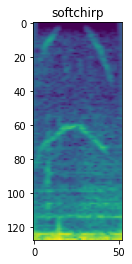

KeyboardInterrupt: Interrupted by user

In [6]:
check_certain_classes = False
classes_to_check = 'all'
classes_to_ignore = ['noise', 'softchirp']

recs_metadata = pd.read_csv(path_to_recordings_metadata + recordings_metadata_name)
filters_mask = filter_recs_metadata(recs_metadata, dates = dates, colonies = colonies, 
                                         stages = stages, experiments = experiments)
sr = 22050
recs_to_check = recs_metadata[filters_mask]
total_recs = len(recs_to_check)
print('%d recs to check' % len(recs_to_check))
checked = 0
for rec_path, rec_name in recs_to_check[['path', 'name']].values:
    checked += 1
    rec_ind = np.where(recs_metadata['name'] == rec_name)[0][0]
    rec_stage = recs_metadata['processing stage'][recs_metadata['name'] == rec_name].iloc[0]
    rec_new_stage = rec_stage + ' and checked'

    print('Type shortcut for class to make relabel into this class',
          'Type nothing if label is good as it is')
    
    df_txt = pd.read_csv(rec_path + rec_name.replace('npy', 'txt'), sep = '\t')
    rec = np.load(rec_path + rec_name)
    print('Checking %d sounds from the recording %s' % (len(df_txt), rec_name))
    for ind in range(len(df_txt)):
        s, e = df_txt[['s', 'e']].iloc[ind]
        cl = df_txt['cl'].iloc[ind]
        if check_certain_classes:
            if cl in classes_to_ignore:
                continue
            if classes_to_check != 'all' and cl not in classes_to_check:
                continue

        s_ind = int(sr * s)
        e_ind = int(sr * e)
        sound = rec[s_ind : e_ind]
        im = make_image(sound)
        plt.imshow(im)
        plt.title(cl)
        plt.show()
        inp = input()
        new_cl = decode(inp, cl)

        while new_cl == 'error':
            print('Abbreviation not recognized, repeat!')
            inp = input()
            new_cl = decode(inp, cl)
        if new_cl != cl:
            print('Relabeled into %s' % new_cl)
        else:
            print('Keeping label %s' % cl)
            
        df_txt['cl'].iloc[ind] = new_cl

    print('Saving updated txt, updating recordings processing stage to', rec_new_stage)
    print('Checked %d/%d' %(checked, total_recs))
    if not check_certain_classes:
        recs_metadata['processing stage'].iloc[rec_ind] = rec_new_stage
    
    recs_metadata.to_csv(path_to_recordings_metadata + recordings_metadata_name, index =  None)
    df_txt.to_csv(rec_path + rec_name.replace('npy',  'txt'), index = None, sep = '\t')
    